In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sys
import os
project_root = os.path.abspath("..") 
sys.path.append(os.path.join(project_root, "scripts"))
from linear_regression import LinearRegressionGD

In [2]:
# Load Dataset
data_path = "../data/insurance.csv"
df = pd.read_csv(data_path)

# Display dataset information
print("Data loaded successfully!")
print(df.head())
print(df.info())
print("Columns:", df.columns)

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

Data loaded successfully!
   index  age     sex     bmi  children smoker     region      charges
0      0   19  female  27.900         0    yes  southwest  16884.92400
1      1   18    male  33.770         1     no  southeast   1725.55230
2      2   28    male  33.000         3     no  southeast   4449.46200
3      3   33    male  22.705         0     no  northwest  21984.47061
4      4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage

In [3]:
if df is not None:
    df = df.drop(columns=['index'], errors='ignore')
# Feature Engineering - Adding New Features

# 1️⃣ Corrected BMI Categories (Ensure `inf` for upper bound)
if df is not None:
        df['bmi_category'] = pd.cut(df['bmi'], 
                                bins=[0, 18.5, 25, 30, float('inf')], 
                                labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
# 2️⃣ Create an Interaction Feature: Age × BMI
if df is not None:
    df['age_bmi_interaction'] = df['age'] * df['bmi']
# One-Hot Encode categorical features (including new features)
categorical_features = ['sex', 'smoker', 'region', 'bmi_category']
numerical_features = ['age', 'bmi', 'children', 'age_bmi_interaction']

ohe = ColumnTransformer([('encoder', OneHotEncoder(drop='first'), categorical_features)], remainder='passthrough')

# Extract features (X) and target (y)
if df is not None:
    features = ohe.fit_transform(df.drop(columns=['charges']))
# Apply log transformation to target variable
if df is not None:
    target = np.log(df['charges'].values)
# Confirm preprocessing
print(f"Features Shape: {features.shape}, Target Shape: {target.shape}")
print("\nFirst 5 Log-Transformed Target Values (y):")
print(target[:5])

Features Shape: (1338, 12), Target Shape: (1338,)

First 5 Log-Transformed Target Values (y):
[9.73417643 7.45330245 8.40053847 9.9980916  8.26019685]


In [4]:
# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize only numerical features
scaler = StandardScaler()

# Identify numeric feature indices (assumes categorical features are first in `features`)
num_features_start = len(ohe.named_transformers_['encoder'].get_feature_names_out())
X_train[:, num_features_start:] = scaler.fit_transform(X_train[:, num_features_start:])
X_test[:, num_features_start:] = scaler.transform(X_test[:, num_features_start:])

# Confirm the split
print(f"Training Set Shape: {X_train.shape}, Testing Set Shape: {X_test.shape}")

Training Set Shape: (1070, 12), Testing Set Shape: (268, 12)


In [5]:
# Initialize the Linear Regression model
try:
    lr = LinearRegressionGD(learning_rate=0.001, n_iter=5000)  # Use n_iter

    print("Custom Linear Regression model imported successfully!")
except NameError:
    print("Error: LinearRegressionGD is not defined. Ensure it's correctly imported.")



Custom Linear Regression model imported successfully!


In [6]:
# Train the Linear Regression model
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Calculate and display MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")


Mean Squared Error on Test Set: 6.7922


In [7]:
if hasattr(lr, 'costs') and len(lr.costs) > 0:
    print("Cost values exist, proceeding with plotting.")
else:
    print("No cost values recorded. Ensure the model has been trained.")


Cost values exist, proceeding with plotting.


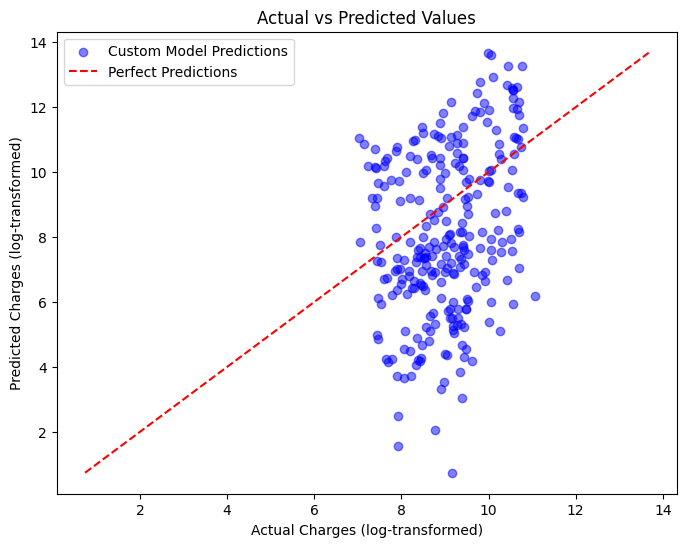

In [8]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Custom Model Predictions", color="blue")

# Add the reference line (Perfect Predictions)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label="Perfect Predictions")

plt.xlabel('Actual Charges (log-transformed)')
plt.ylabel('Predicted Charges (log-transformed)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()
